# WikiTLDR

A summarization/simplification dataset

In [42]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [43]:
conn = sqlite3.connect('../raw_data/simple_en_wiki.db')
cursor = conn.cursor()

df = pd.read_sql_query("SELECT * FROM articles", conn)
df.drop(columns=['id'], inplace=True)
df.head()

,title,input_text,target_text
0,Johan August Arfwedson,Johan August Arfwedson (12 January 1792 – 28 O...,Johan August Arfwedson (12 January 1792 – 28 O...
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,..."
2,Moundou,Moundou (Arabic: موندو) is the second-largest ...,Moundou is the capital of the Logone Occidenta...
3,Kamrieng District,Kamrieng (Khmer: កំរៀង) is a district (srok) o...,Kamrieng District (Khmer: កំរៀង) is a district...
4,Mother 1 + 2,Mother (known as EarthBound outside Japan) is ...,Mother 1 + 2 is a video game for the Game Boy ...


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38295 entries, 0 to 38294
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        38295 non-null  object
 1   input_text   38295 non-null  object
 2   target_text  38163 non-null  object
dtypes: object(3)
memory usage: 897.7+ KB


In [45]:
df.isna().sum()

title            0
input_text       0
target_text    132
dtype: int64

We replace empty strings `""` with nulls. Because they *are* null values.

In [46]:
df.replace("", np.nan, inplace=True)

In [47]:
df.isna().sum()

title            0
input_text       0
target_text    167
dtype: int64

In [48]:
df.dropna(inplace=True)

In [49]:
df.duplicated().sum()

3876

In [50]:
df[df.duplicated()]

,title,input_text,target_text
1515,Mizrahi music,Mizrahi music (Hebrew: מוזיקה מזרחית muzika mi...,Mizrahi music (Hebrew: מוזיקה מזרחית) is a mus...
1683,Fantaisie-Impromptu,Frédéric Chopin's Fantaisie-Impromptu (Polish:...,Frédéric Chopin's Fantaisie-Impromptu in C♯ mi...
1769,"Stonewall County, Texas",Stonewall County is a county located in the U....,Stonewall County is a county in the U.S. state...
1844,Hanoi,Hanoi (Vietnamese: Hà Nội ) is the capital and...,Hanoi (Vietnamese: Hà Nội) is the capital of V...
1986,"Saint-Martin, Gers",Saint-Martin (French pronunciation: [sɛ̃ maʁtɛ...,Saint-Martin is a commune in the Gers departme...
...,...,...,...
38251,K. Balachander filmography,This following is the list of films to which K...,"K. Balachander has written, directed nearly 80..."
38266,Magda Amo Rius,"Magda Amo Rius (born July 23, 1973, in Barcelo...","Magda Amo Rius (born July 23, 1973 in Barcelon..."
38272,Ohio Players,"Ohio Players are an American funk band, most p...",The Ohio Players were a funk and R&B band from...
38273,Valbonne,Valbonne (French pronunciation: [valbɔn]; Occi...,Valbonne is a commune. It is found in the regi...


In [51]:
df[df["title"] == "Warangal"]

,title,input_text,target_text
3718,Warangal,Warangal () is a city in the Indian state of T...,"Warangal is a city in Telangana, India. It is ..."
16250,Warangal,Warangal () is a city in the Indian state of T...,"Warangal is a city in Telangana, India. It is ..."


In [52]:
df.drop_duplicates(inplace=True)

In [53]:
df.info()
print("Null values: ", df.isna().sum().sum())
print("Duplicates: ", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 34252 entries, 0 to 38294
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        34252 non-null  object
 1   input_text   34252 non-null  object
 2   target_text  34252 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB
Null values:  0
Duplicates:  0


Replace consecutive newlines `\n` with a single one.

In [54]:
print(df["input_text"].str.contains(r"\n{2,}", regex=True).sum())
print(df["target_text"].str.contains(r"\n{2,}", regex=True).sum())

8875
1033


In [55]:
df["input_text"] = df["input_text"].str.replace(r"\n{2,}", "\n", regex=True)
df["target_text"] = df["target_text"].str.replace(r"\n{2,}", "\n", regex=True)

## Compression Ratio

This is the ratio of the length of the simplified text and the standard English text.

$$
\text{compression\_ratio} = \frac{\text{Length of simplified text}}{\text{Length of standard English text}}
$$

Larger compression ratio values mean larger summaries.

In [56]:
df["compression_ratio"] = df["target_text"].str.len() / \
    df["input_text"].str.len()

In [57]:
df["compression_ratio"].describe()

count    34252.000000
mean         0.841302
std          1.313101
min          0.004037
25%          0.292763
50%          0.586799
75%          0.979604
max         82.583333
Name: compression_ratio, dtype: float64

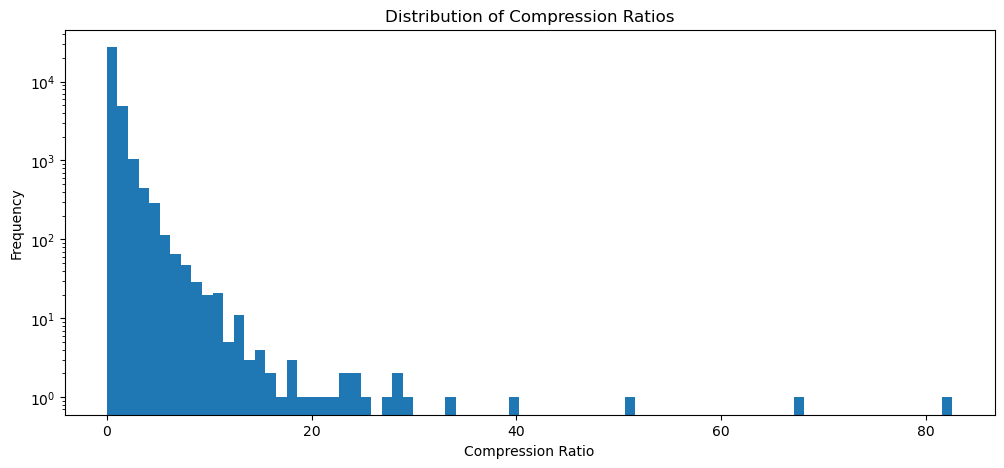

In [58]:
plt.figure(figsize=(12, 5))
plt.hist(df['compression_ratio'], bins=80, log=True)
plt.xlabel('Compression Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Compression Ratios')
plt.show()

In [59]:
largest = df.iloc[np.argmax(df["compression_ratio"])]
print(largest)
print(largest["input_text"])
print()
print(largest["target_text"])

title                                                           S.A.S.
input_text                                    SAS or Sas may refer to:
target_text          The S.A.S. or Special Air Service, is a Specia...
compression_ratio                                            82.583333
Name: 37696, dtype: object
SAS or Sas may refer to:

The S.A.S. or Special Air Service, is a Special Operations Organisation of the British Army. It was founded in 1941 to attack behind the German line of defence in North Africa, in World War II. They are one of the best schooled units in the world, that makes them very valuable. There are about 500 active SAS soldiers.
The SAS is a secret organisation. Its members often do not tell anyone except close family that they are in it. The British Ministry of Defence (MOD) rarely speaks of the SAS and mission details are never released until much later.
The badge of the organisation was originally designed as a flaming sword of Damocles but ended up as a winged d

In [60]:
df = df[(df["compression_ratio"] > 0.2) & (df["compression_ratio"] < 1.2)]

Articles titled "List of x things" on Wikipedia are not considered proper summarizations because they typically consist of enumerations rather than narrative content. These lists do not provide much context or detailed information to summarize.

In [61]:
df.drop(df[df["title"].str.contains("^List of", regex=True)].index, inplace=True)

In [62]:
large_summaries = df[df["compression_ratio"] > 1]

In [63]:
large_summaries.sort_values("compression_ratio", ascending=False).head()

,title,input_text,target_text,compression_ratio
385,Zip drive,The Zip drive is a removable floppy disk stora...,The Zip drive is a data storage device. The co...,1.199732
14029,Tanjong Pagar MRT station,Tanjong Pagar MRT station is an underground Ma...,Tanjong Pagar MRT Station (EW15) is an undergr...,1.199541
3393,I've Been to the Mountaintop,"""I've Been to the Mountaintop"" is the popular ...",I've Been to the Mountaintop is the name of th...,1.199187
2102,Carlos Squeo,"Carlos Vicente Squeo (4 June 1948 in Dock Sud,...","Carlos Vicente Squeo (4 June 1948 in Dock Sud,...",1.199187
2712,Fixed-point theorem,"In mathematics, a fixed-point theorem is a res...","In mathematics, a fixed-point theorem is a the...",1.199029


In [64]:
len(large_summaries)

2444

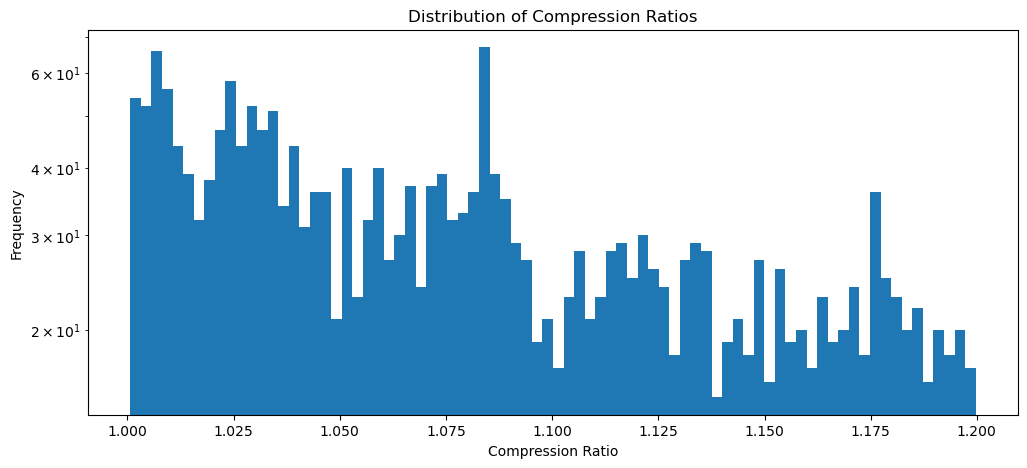

In [65]:
plt.figure(figsize=(12, 5))
plt.hist(large_summaries['compression_ratio'], bins=80, log=True)
plt.xlabel('Compression Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Compression Ratios')
plt.show()

In [67]:
sample = large_summaries.sample(1)
print(sample.index)
print(sample["input_text"].values[0])
print("-" * 40 + "Target Text" + "-" * 40)
print(sample["target_text"].values[0])

Index([32999], dtype='int64')
José Ignacio Gabriel Jorge Retes Balzaretti (March 25, 1947 – April 20, 2020) was a Mexican film director, writer, producer, and actor. His 1977 film Paper Flowers was entered into the 28th Berlin International Film Festival. His 1979 film Broken Flag was entered into the 11th Moscow International Film Festival. His 1999 film A Sweet Scent of Death was entered into the 21st Moscow International Film Festival.

----------------------------------------Target Text----------------------------------------
José Ignacio Gabriel Jorge Retes Balzaretti (25 March 1947 – 20 April 2020) was a Mexican movie director, writer, producer and actor. His movie, Paper Flowers (1977), was entered into the 28th Berlin International Film Festival. Two of his other movies, Broken Flag (1979) and A Sweet Scent of Death (1999), were both entered into the Moscow International Film Festival.
Retes died on 20 April 2020 at the age of 73.


In [68]:
refer_to_articles = df["input_text"].str.contains(r"may refer to",
                                                  case=False,
                                                  regex=True)
df = df[~refer_to_articles]

In [69]:
df["compression_ratio"].describe()

count    23751.000000
mean         0.612055
std          0.277431
min          0.200065
25%          0.365253
50%          0.581197
75%          0.844174
max          1.199732
Name: compression_ratio, dtype: float64

In [72]:
# minimum length thresholds
min_input_words = 10
min_target_words = 5

min_compression_ratio = 0.2
max_compression_ratio = 1.


filtered_df = df[
    (df['input_text'].str.split().str.len() >= min_input_words) &
    (df['target_text'].str.split().str.len() >= min_target_words)
    # (df['compression_ratio'] >= min_compression_ratio) &
    # (df['compression_ratio'] <= max_compression_ratio)
]

print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(filtered_df)}")
print(f"Removed entries: {len(df) - len(filtered_df)}")

Original dataset size: 23751
Filtered dataset size: 23749
Removed entries: 2


In [73]:
filtered_df.sort_values("compression_ratio", ascending=False).head()

,title,input_text,target_text,compression_ratio
385,Zip drive,The Zip drive is a removable floppy disk stora...,The Zip drive is a data storage device. The co...,1.199732
14029,Tanjong Pagar MRT station,Tanjong Pagar MRT station is an underground Ma...,Tanjong Pagar MRT Station (EW15) is an undergr...,1.199541
3393,I've Been to the Mountaintop,"""I've Been to the Mountaintop"" is the popular ...",I've Been to the Mountaintop is the name of th...,1.199187
2102,Carlos Squeo,"Carlos Vicente Squeo (4 June 1948 in Dock Sud,...","Carlos Vicente Squeo (4 June 1948 in Dock Sud,...",1.199187
2712,Fixed-point theorem,"In mathematics, a fixed-point theorem is a res...","In mathematics, a fixed-point theorem is a the...",1.199029


In [74]:
filtered_df.info()
print()
filtered_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 23749 entries, 0 to 38293
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              23749 non-null  object 
 1   input_text         23749 non-null  object 
 2   target_text        23749 non-null  object 
 3   compression_ratio  23749 non-null  float64
dtypes: float64(1), object(3)
memory usage: 927.7+ KB



,compression_ratio
count,23749.000000
mean,0.612022
std,0.277420
min,0.200065
25%,0.365209
50%,0.581126
75%,0.844046
max,1.199732


In [75]:
sample = filtered_df.sample(1)
print(sample.index)
print(sample["input_text"].values[0])
print("-" * 40 + "Target Text" + "-" * 40)
print(sample["target_text"].values[0])

Index([15220], dtype='int64')
Pouldergat (French pronunciation: [puldɛʁɡat]; Breton: Pouldregad) is a commune in the Finistère department of Brittany in north-western France.
----------------------------------------Target Text----------------------------------------
Pouldergat (Breton: Pouldregad) is a commune. It is found in the region Brittany in the Finistère department in the northwest of France.


Text within parenthesis may contain unicode values like non English charactes. Like Japanese kanji or greek letters.

It may be lazy but I'd rather remove the parenthesis and the text within it

In [76]:
# find contents within parentheses
def rm_parentheses_content(text):
    return re.sub(r"\([^)]*\)", "", text)


# remove them
filtered_df["input_text"] = filtered_df["input_text"].apply(
    rm_parentheses_content)
filtered_df["target_text"] = filtered_df["target_text"].apply(
    rm_parentheses_content)

/tmp/ipykernel_85996/1992106834.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["input_text"] = filtered_df["input_text"].apply(
/tmp/ipykernel_85996/1992106834.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["target_text"] = filtered_df["target_text"].apply(


In [77]:
filtered_df

,title,input_text,target_text,compression_ratio
0,Johan August Arfwedson,Johan August Arfwedson was a Swedish chemist...,Johan August Arfwedson was a Swedish chemist....,0.862500
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,...",0.241987
2,Moundou,Moundou is the second-largest city in Chad an...,Moundou is the capital of the Logone Occidenta...,0.617577
3,Kamrieng District,Kamrieng is a district of Battambang provinc...,Kamrieng District is a district of Battamban...,1.094737
6,"Lone Rock, Iowa","Lone Rock is a city in Kossuth County, Iowa, U...",Lone Rock is a city in Iowa in the United States.,0.230047
...,...,...,...,...
38288,Shabestar,Shabestar is a city in the Central District o...,Shabestar is a city and is the capital of Sha...,0.461874
38290,Jack Garfein,Jakob Garfein was an American film and theatr...,Jack Garfein was an American director and act...,0.426441
38291,Balinghem,Balinghem is a commune in the Pas-de-Calais d...,Balinghem is a commune. It is found in the reg...,0.870504
38292,Limony,Limony is a commune in the Ardèche department...,Limony is a commune in the Ardèche départemen...,0.582609


In [78]:
%pip install -q textstat rouge

Note: you may need to restart the kernel to use updated packages.


In [79]:
from textstat import textstat
from rouge import Rouge

In [80]:
# calculate readability score
filtered_df['readability_score'] = filtered_df['target_text'].apply(
    textstat.flesch_reading_ease)

/tmp/ipykernel_85996/3904329003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['readability_score'] = filtered_df['target_text'].apply(


In [ ]:
# calculating ROUGE scores
rouge = Rouge()


def calculate_rouge(row):
    scores = rouge.get_scores(row['target_text'], row['input_text'])[0]
    return scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']


filtered_df[['rouge-1', 'rouge-2', 'rouge-l']
            ] = filtered_df.apply(calculate_rouge, axis=1, result_type='expand')

filtered_df.head()

<ipython-input-43-52d23af727b7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['readability_score'] = filtered_df['target_text'].apply(
<ipython-input-43-52d23af727b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['rouge-1', 'rouge-2', 'rouge-l']
<ipython-input-43-52d23af727b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

,title,input_text,target_text,compression_ratio,readability_score,rouge-1,rouge-2,rouge-l
0,Johan August Arfwedson,Johan August Arfwedson was a Swedish chemist...,Johan August Arfwedson was a Swedish chemist....,0.862500,53.88,0.864865,0.756757,0.864865
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,...",0.241987,58.62,0.224719,0.051282,0.224719
2,Moundou,Moundou is the second-largest city in Chad an...,Moundou is the capital of the Logone Occidenta...,0.617577,86.71,0.538462,0.333333,0.538462
6,"Lone Rock, Iowa","Lone Rock is a city in Kossuth County, Iowa, U...",Lone Rock is a city in Iowa in the United States.,0.230047,68.77,0.465116,0.285714,0.465116
8,Japan Mint,The Japan Mint is an Independent Administrati...,The Japan Mint is an Incorporated Administrat...,0.628272,43.69,0.470588,0.303797,0.470588


In [81]:
min_readability_score = 40

filtered_df = filtered_df[
    (filtered_df['readability_score'] >= min_readability_score)
]

In [82]:
filtered_df.info()
filtered_df

<class 'pandas.core.frame.DataFrame'>
Index: 22214 entries, 0 to 38293
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              22214 non-null  object 
 1   input_text         22214 non-null  object 
 2   target_text        22214 non-null  object 
 3   compression_ratio  22214 non-null  float64
 4   readability_score  22214 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.0+ MB


,title,input_text,target_text,compression_ratio,readability_score
0,Johan August Arfwedson,Johan August Arfwedson was a Swedish chemist...,Johan August Arfwedson was a Swedish chemist....,0.862500,70.80
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,...",0.241987,67.08
2,Moundou,Moundou is the second-largest city in Chad an...,Moundou is the capital of the Logone Occidenta...,0.617577,86.71
6,"Lone Rock, Iowa","Lone Rock is a city in Kossuth County, Iowa, U...",Lone Rock is a city in Iowa in the United States.,0.230047,102.61
8,Japan Mint,The Japan Mint is an Independent Administrati...,The Japan Mint is an Incorporated Administrat...,0.628272,52.15
...,...,...,...,...,...
38288,Shabestar,Shabestar is a city in the Central District o...,Shabestar is a city and is the capital of Sha...,0.461874,76.22
38290,Jack Garfein,Jakob Garfein was an American film and theatr...,Jack Garfein was an American director and act...,0.426441,74.79
38291,Balinghem,Balinghem is a commune in the Pas-de-Calais d...,Balinghem is a commune. It is found in the reg...,0.870504,69.79
38292,Limony,Limony is a commune in the Ardèche department...,Limony is a commune in the Ardèche départemen...,0.582609,68.77


In [83]:
filtered_df.to_json("../processed_data/data.jsonl", orient="records", lines=True)

In [84]:
df = pd.read_json("../processed_data/data.jsonl", lines=True)

In [85]:
df

,title,input_text,target_text,compression_ratio,readability_score
0,Johan August Arfwedson,Johan August Arfwedson was a Swedish chemist...,Johan August Arfwedson was a Swedish chemist....,0.862500,70.80
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,...",0.241987,67.08
2,Moundou,Moundou is the second-largest city in Chad an...,Moundou is the capital of the Logone Occidenta...,0.617577,86.71
3,"Lone Rock, Iowa","Lone Rock is a city in Kossuth County, Iowa, U...",Lone Rock is a city in Iowa in the United States.,0.230047,102.61
4,Japan Mint,The Japan Mint is an Independent Administrati...,The Japan Mint is an Incorporated Administrat...,0.628272,52.15
...,...,...,...,...,...
22209,Shabestar,Shabestar is a city in the Central District o...,Shabestar is a city and is the capital of Sha...,0.461874,76.22
22210,Jack Garfein,Jakob Garfein was an American film and theatr...,Jack Garfein was an American director and act...,0.426441,74.79
22211,Balinghem,Balinghem is a commune in the Pas-de-Calais d...,Balinghem is a commune. It is found in the reg...,0.870504,69.79
22212,Limony,Limony is a commune in the Ardèche department...,Limony is a commune in the Ardèche départemen...,0.582609,68.77
